# ASHRAE – Great Energy Predictor III

### Introduction:
We are using a dataset related to ASHRAE – Great Energy Predictor III (How much energy will a building consume?). The goal is to develop models from ASHRAE’s 2016 data in order to better understand metered building energy usage in the following areas: chilled water, electric, hot water, and steam meters. The data comes from over 1,000 buildings over a one-year timeframe. The method chosen to solve the problem is Linear Regression.
    
### Objective

The objective of this notebook is to provide a prdictive models using LSTM to predict
How much energy will a building consume? 

The train dataset has our target variable called “meter reading” with datatype float, hence the task could be solved by RNN. The following methodology is used: 



### Outline

1.Data Understanding

2.Data Preparation

2.1 Merge tables

2.2 Droping columns and filling null value for column: 'air_temperature', 'wind_speed', 'precip_depth_1_hr', 'cloud_coverage'
2.3 Prepare train & test data for LSTM

3.Modeling    







Let's dive in!

# imports

In [0]:
#to load data sets from drive
from google.colab import drive

import pandas as pd
import numpy as np

#viz
import matplotlib.pyplot as plt
import seaborn as sns


#Scaling
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

#Keras
from keras.models import Sequential,Model
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Dropout, GRU, CuDNNLSTM, Input
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD, Nadam
from keras.layers.advanced_activations import LeakyReLU, PReLU
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

#Save model
from keras.models import load_model

In [0]:
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
#Load data
train=pd.read_csv('drive/My Drive/dl_competition/train.csv')
building_meta=pd.read_csv('drive/My Drive/dl_competition/building_metadata.csv')
weather=pd.read_csv('drive/My Drive/dl_competition/weather_train.csv')


### 1.Data Understanding

#### 1.1 Train data

In [0]:
train.dtypes


building_id        int64
meter              int64
timestamp         object
meter_reading    float64
dtype: object

In [0]:
train.isna().sum()

building_id      0
meter            0
timestamp        0
meter_reading    0
dtype: int64

In [0]:
#Convert timestamp  into time 
train['timestamp']=pd.to_datetime(train.timestamp)
train["month"]=train.timestamp.dt.month
train["day"]=train.timestamp.dt.day

In [0]:
train.describe()

,building_id,meter,meter_reading,month,day
count,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07
mean,7.992780e+02,6.624412e-01,2.117121e+03,6.578453e+00,1.576123e+01
std,4.269133e+02,9.309921e-01,1.532356e+05,3.436662e+00,8.820535e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01,4.000000e+00,8.000000e+00
50%,8.950000e+02,0.000000e+00,7.877500e+01,7.000000e+00,1.600000e+01
75%,1.179000e+03,1.000000e+00,2.679840e+02,1.000000e+01,2.300000e+01
max,1.448000e+03,3.000000e+00,2.190470e+07,1.200000e+01,3.100000e+01


{'boxes': [<matplotlib.lines.Line2D at 0x7f5d5dedd240>],
 'caps': [<matplotlib.lines.Line2D at 0x7f5d5deddb70>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f5d5def1588>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f5d5def1240>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f5d5dedd4e0>,
  <matplotlib.lines.Line2D at 0x7f5d5dedd828>]}

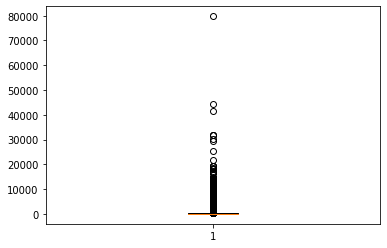

In [0]:
plt.boxplot(train[train.meter==0].meter_reading)

In [0]:
train[train.meter==0].describe()

,building_id,meter,meter_reading,month,day
count,1.206091e+07,12060910.0,1.206091e+07,1.206091e+07,1.206091e+07
mean,7.066480e+02,0.0,1.708256e+02,6.552058e+00,1.576247e+01
std,4.152330e+02,0.0,3.808343e+02,3.443575e+00,8.812518e+00
min,0.000000e+00,0.0,0.000000e+00,1.000000e+00,1.000000e+00
25%,3.450000e+02,0.0,1.950000e+01,4.000000e+00,8.000000e+00
50%,6.980000e+02,0.0,6.283190e+01,7.000000e+00,1.600000e+01
75%,1.063000e+03,0.0,1.700750e+02,1.000000e+01,2.300000e+01
max,1.448000e+03,0.0,7.976900e+04,1.200000e+01,3.100000e+01


In [0]:
train[train.meter==0][train.meter_reading>70000]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,building_id,meter,timestamp,meter_reading,month,day
15975226,993,0,2016-10-17 07:00:00,79769.0,10,17


In [0]:
train[train.meter==0][train.building_id==993][train.month == 10][train.day == 17]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,building_id,meter,timestamp,meter_reading,month,day
15959271,993,0,2016-10-17 00:00:00,0.0,10,17
15961428,993,0,2016-10-17 01:00:00,31921.0,10,17
15963761,993,0,2016-10-17 02:00:00,0.0,10,17
15966098,993,0,2016-10-17 03:00:00,0.0,10,17
15968436,993,0,2016-10-17 04:00:00,0.0,10,17
15970772,993,0,2016-10-17 05:00:00,0.0,10,17
15973109,993,0,2016-10-17 06:00:00,0.0,10,17
15975226,993,0,2016-10-17 07:00:00,79769.0,10,17
15977554,993,0,2016-10-17 08:00:00,1432.0,10,17
15979914,993,0,2016-10-17 09:00:00,1493.0,10,17


In [0]:
building_meta[building_meta.building_id==993]

,site_id,building_id,primary_use,square_feet
993,9,993,Education,428647


31921 & 79769. seems to be outliers since building993 has as primary_use education at 7pm and 1pm meter reading would be 0

{'boxes': [<matplotlib.lines.Line2D at 0x7f5d5dc6dc50>],
 'caps': [<matplotlib.lines.Line2D at 0x7f5d5dc754e0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f5d5dc75eb8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f5d5dc75b70>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f5d5dc6dda0>,
  <matplotlib.lines.Line2D at 0x7f5d5dc75198>]}

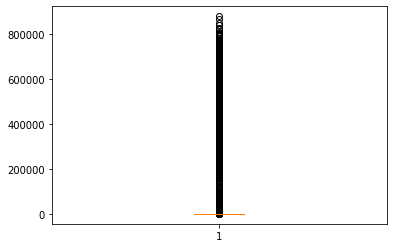

In [0]:
plt.boxplot(train[train.meter==1].meter_reading)

In [0]:
train[train.meter==1].describe()

,building_id,meter,meter_reading,month,day
count,4.182440e+06,4182440.0,4.182440e+06,4.182440e+06,4.182440e+06
mean,8.871572e+02,1.0,6.333639e+02,6.633137e+00,1.575326e+01
std,4.305578e+02,0.0,7.988213e+03,3.417093e+00,8.844727e+00
min,7.000000e+00,1.0,0.000000e+00,1.000000e+00,1.000000e+00
25%,7.470000e+02,1.0,1.132880e+01,4.000000e+00,8.000000e+00
50%,9.900000e+02,1.0,1.204870e+02,7.000000e+00,1.600000e+01
75%,1.242000e+03,1.0,4.643140e+02,1.000000e+01,2.300000e+01
max,1.413000e+03,1.0,8.803740e+05,1.200000e+01,3.100000e+01


In [0]:
train[train.meter==1][train.meter_reading>880000]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,building_id,meter,timestamp,meter_reading,month,day
13851463,778,1,2016-09-09 17:00:00,880374.0,9,9


In [0]:
building_meta[building_meta.building_id==778]

,site_id,building_id,primary_use,square_feet
778,6,778,Entertainment/public assembly,108339


{'boxes': [<matplotlib.lines.Line2D at 0x7f5d5dc3a6a0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f5d5dc3aef0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f5d5dc43908>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f5d5dc435c0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f5d5dc3a7f0>,
  <matplotlib.lines.Line2D at 0x7f5d5dc3aba8>]}

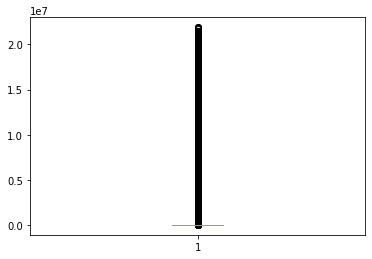

In [0]:
plt.boxplot(train[train.meter==2].meter_reading)

{'boxes': [<matplotlib.lines.Line2D at 0x7f5d5c1b2fd0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f5d5c1bc860>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f5d5c1c4278>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f5d5c1bcef0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f5d5c1bc160>,
  <matplotlib.lines.Line2D at 0x7f5d5c1bc518>]}

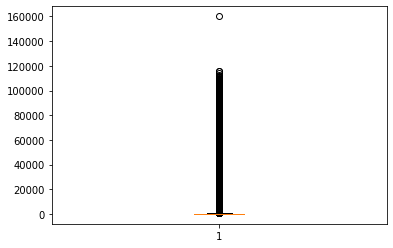

In [0]:
plt.boxplot(train[train.meter==3].meter_reading)

In [0]:
train[train.building_id==0]['timestamp']

0          2016-01-01 00:00:00
2301       2016-01-01 01:00:00
4594       2016-01-01 02:00:00
6893       2016-01-01 03:00:00
9189       2016-01-01 04:00:00
                   ...        
20204274   2016-12-31 19:00:00
20206637   2016-12-31 20:00:00
20209003   2016-12-31 21:00:00
20211368   2016-12-31 22:00:00
20213734   2016-12-31 23:00:00
Name: timestamp, Length: 8784, dtype: datetime64[ns]

- We have energy measurement by building and by meter each 1hour along one year(2016)

#### Annual average of energy consumption by building 

In [0]:
dff=train[['building_id','meter','meter_reading']].groupby(['building_id','meter']).mean()

In [0]:
dff.reset_index(inplace=True)
dff.head()

,building_id,meter,meter_reading
0,0,0,146.454978
1,1,0,74.865393
2,2,0,14.551385
3,3,0,235.549966
4,4,0,976.556746


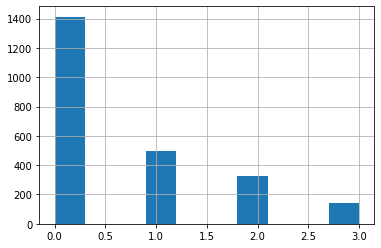

In [0]:
dff.meter.hist()

- 1413 out of 1449 buildings are using electricity

#### Energy annual consumption


In [0]:
tags=['electricity', 'chilled water', 'steam      ', 'hot water']
d=train.groupby('meter').sum()["meter_reading"]
j=0
for i in d:
    print(' Annual consumption of %s \t : %f' % (tags[j],i))
    j+=1

 Annual consumption of electricity 	 : 2060312626.892362
 Annual consumption of chilled water 	 : 2649006611.237669
 Annual consumption of steam       	 : 37602862262.494247
 Annual consumption of hot water 	 : 487749888.206928


In [0]:
train[train.building_id==403]

,building_id,meter,timestamp,meter_reading,month,day
19085659,403,0,2016-12-12 01:00:00,44.35,12,12
19088023,403,0,2016-12-12 02:00:00,45.45,12,12
19090387,403,0,2016-12-12 03:00:00,44.82,12,12
19092751,403,0,2016-12-12 04:00:00,45.11,12,12
19095115,403,0,2016-12-12 05:00:00,44.73,12,12
...,...,...,...,...,...,...
20204864,403,0,2016-12-31 19:00:00,43.66,12,31
20207227,403,0,2016-12-31 20:00:00,43.64,12,31
20209593,403,0,2016-12-31 21:00:00,43.89,12,31
20211958,403,0,2016-12-31 22:00:00,44.37,12,31


In [0]:
train.building_id.nunique()

1449

In [0]:
t=set([train[train.building_id==i]['timestamp'].shape[0] for i in range(1449)])
max([train[train.building_id==i][train.meter==0]['timestamp'].shape[0] for i in range(1449)])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


8784

- max number of measurement across a year for one type of energy 8784

#### Building_id0 average consumption per month of electricity

In [0]:
g1 = train[train.building_id==0][train.meter==0][['month','meter_reading']].groupby('month').mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


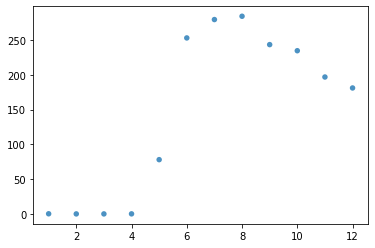

In [0]:
plt.scatter( range(1,13),g1, alpha=0.8, edgecolors='none', s=30)

#### Visualize Building_id1448 average consumption per month for each type of energy


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


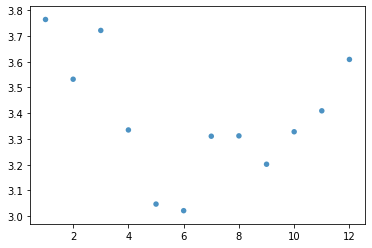

In [0]:
g1 = train[train.building_id==1448][train.meter==0][['month','meter_reading']].groupby('month').mean()
plt.scatter( range(1,13),g1, alpha=0.8, edgecolors='none', s=30)

#### Visualize Building_id700 average consumption per month for each type of energy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


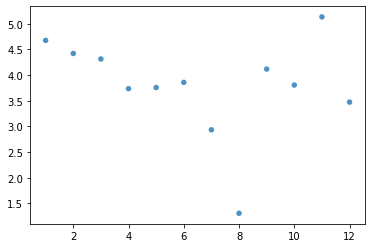

In [0]:
g1 = train[train.building_id==700][train.meter==0][['month','meter_reading']].groupby('month').mean()
plt.scatter( range(1,13),g1, alpha=0.8, edgecolors='none', s=30)

### 1.2 Building_meta_data

In [0]:
building_meta.isna().sum()

site_id        0
building_id    0
primary_use    0
square_feet    0
dtype: int64

In [0]:
building_meta.describe()

,site_id,building_id,square_feet
count,1449.000000,1449.000000,1449.000000
mean,6.952381,724.000000,92111.776398
std,5.003432,418.434583,110769.950997
min,0.000000,0.000000,283.000000
25%,3.000000,362.000000,23012.000000
50%,5.000000,724.000000,57673.000000
75%,13.000000,1086.000000,115676.000000
max,15.000000,1448.000000,875000.000000


In [0]:
building_meta[building_meta.year_built==2017]

In [0]:
train[train.building_id==363]

,building_id,meter,timestamp,meter_reading,month,day
523,363,0,2016-01-01 00:00:00,32.05,1,1
2822,363,0,2016-01-01 01:00:00,32.57,1,1
5117,363,0,2016-01-01 02:00:00,32.80,1,1
7415,363,0,2016-01-01 03:00:00,33.92,1,1
9710,363,0,2016-01-01 04:00:00,35.58,1,1
...,...,...,...,...,...,...
20204824,363,0,2016-12-31 19:00:00,43.63,12,31
20207187,363,0,2016-12-31 20:00:00,43.27,12,31
20209553,363,0,2016-12-31 21:00:00,43.37,12,31
20211918,363,0,2016-12-31 22:00:00,36.28,12,31


- building_id 363 is using electricity for 1 year before it has been built! 

Unconsistent year of built

In [0]:
building_meta.primary_use.unique()

array(['Education', 'Lodging/residential', 'Office',
       'Entertainment/public assembly', 'Other', 'Retail', 'Parking',
       'Public services', 'Warehouse/storage', 'Food sales and service',
       'Religious worship', 'Healthcare', 'Utility', 'Technology/science',
       'Manufacturing/industrial', 'Services'], dtype=object)

In [0]:
building_meta.isna().sum()

site_id        0
building_id    0
primary_use    0
square_feet    0
dtype: int64

### 1.3 Weather data


In [0]:
weather.describe()

,site_id,air_temperature,cloud_coverage,sea_level_pressure,wind_speed
count,139773.000000,139773.000000,139773.000000,139773.000000,139773.000000
mean,7.478977,14.418672,2.835498,1015.971407,3.558912
std,4.604744,10.626160,3.157197,7.418949,2.334981
min,0.000000,-28.900000,0.000000,968.200000,0.000000
25%,3.000000,7.200000,0.000000,1012.100000,2.100000
50%,7.000000,15.000000,2.000000,1015.800000,3.100000
75%,11.000000,22.200000,6.000000,1020.400000,5.000000
max,15.000000,47.200000,9.000000,1045.500000,19.000000


- remove precip_depth_1_hr since it has 75% of its values 0 && 50289 NaN

In [0]:
weather.isna().sum()

site_id               0
timestamp             0
air_temperature       0
cloud_coverage        0
sea_level_pressure    0
wind_speed            0
dtype: int64

In [0]:
weather.site_id.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [0]:
weather[ weather.air_temperature.isna() ][['site_id','timestamp']]

,site_id,timestamp


In [0]:
weather[ weather.cloud_coverage.isna() ][['site_id','timestamp']]

,site_id,timestamp


In [0]:
weather[ weather.sea_level_pressure.isna() ][['site_id','timestamp']]

,site_id,timestamp


In [0]:
df=weather[ weather.sea_level_pressure.isna() ][['site_id','timestamp']]
df['timestamp']=pd.to_datetime(df.timestamp)
df['month']=df.timestamp.dt.month
df['day']=df.timestamp.dt.day
t=df.groupby(['site_id','month','day']).count()
t.timestamp.value_counts()

Series([], Name: timestamp, dtype: int64)

In [0]:
t=df[df.site_id == 5].groupby(['month','day']).count()
t.timestamp.value_counts()

Series([], Name: timestamp, dtype: int64)

- even if we have a lot of missing data but if we take a look at our data, we will figure out that we have missing data for some our, so in this case we would be able to fill missing data with near measurement
- we will use ffill: propagate last valid observation forward to next valid to fill nan in these cases
- we used df to see how many days in a site that we don't take measurments for sea pressure, in site_id 5 we have 355 days (year)

In [0]:
building_meta[building_meta.site_id==5].primary_use.value_counts()

Education                        49
Entertainment/public assembly    18
Office                           11
Public services                   5
Manufacturing/industrial          3
Other                             1
Healthcare                        1
Lodging/residential               1
Name: primary_use, dtype: int64

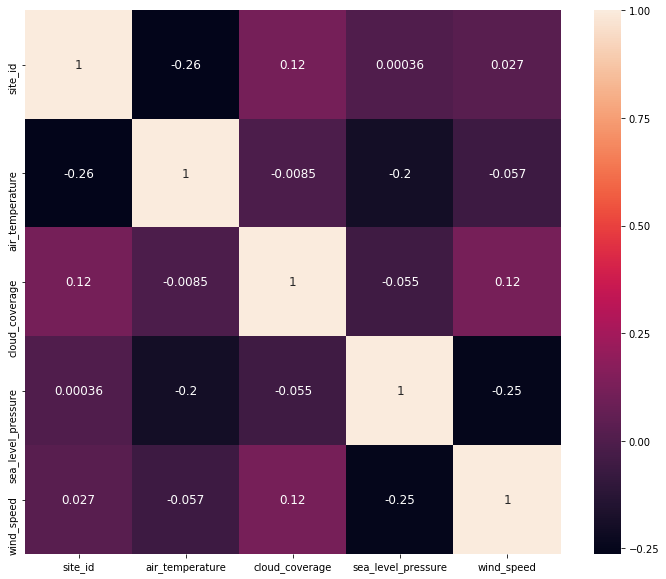

In [0]:
corrmat=weather.corr()
fig,ax=plt.subplots(figsize=(12,10))
sns.heatmap(corrmat,annot=True,annot_kws={'size': 12})

- # air_temperature & dew_temp are correlated we can remove one of them 

### 2.Data preparation & feature selection

In [0]:
#remove 'year_built','floor_count'
building_meta=building_meta[['site_id', 'building_id', 'primary_use', 'square_feet']]
#remove 'dew_temperature', "precip_depth_1_hr"
weather=weather[['site_id', 'timestamp', 'air_temperature', 'cloud_coverage', 'sea_level_pressure', 'wind_speed']]

#fill NaNs with ffillna
weather['air_temperature'].fillna(method='ffill', inplace = True)
weather["cloud_coverage"].fillna(method='ffill', inplace = True)
weather['sea_level_pressure'].fillna(method='ffill', inplace = True)
weather['wind_speed'].fillna(method='ffill', inplace = True)

In [0]:
merged_data=weather.merge(building_meta,left_on='site_id',right_on='site_id',how='left')
merged_data=merged_data[['timestamp', 'air_temperature', 'cloud_coverage',
       'sea_level_pressure', 'wind_speed', 'building_id', 'primary_use',
       'square_feet']]
merged_data=merged_data.merge(train,left_on=['building_id','timestamp'],right_on=['building_id','timestamp'],how='left')

In [0]:
merged_data['meter'].fillna(method='ffill', inplace = True)
merged_data['meter_reading'].fillna(method='ffill', inplace = True)

In [0]:
# Scaling some features
merged_data['meter_reading']=np.log1p(merged_data['meter_reading'])
le=LabelEncoder()
merged_data['primary_use']=le.fit_transform(merged_data['primary_use'])
scaler1=MinMaxScaler()
merged_data[['air_temperature','cloud_coverage','sea_level_pressure','wind_speed','square_feet']]=scaler1.fit_transform(merged_data[['air_temperature','cloud_coverage','sea_level_pressure','wind_speed','square_feet']])
# set index = timestamp
merged_data.set_index('timestamp',inplace=True)

In [0]:
# scaled data
merged_data.head()

,air_temperature,cloud_coverage,sea_level_pressure,wind_speed,building_id,primary_use,square_feet,meter,meter_reading
timestamp,,,,,,,,,
2016-01-01 00:00:00,0.708279,0.666667,0.666235,0.0,0,0,0.008173,0.0,0.0
2016-01-01 00:00:00,0.708279,0.666667,0.666235,0.0,1,0,0.002786,0.0,0.0
2016-01-01 00:00:00,0.708279,0.666667,0.666235,0.0,2,0,0.005822,0.0,0.0
2016-01-01 00:00:00,0.708279,0.666667,0.666235,0.0,3,0,0.026754,0.0,0.0
2016-01-01 00:00:00,0.708279,0.666667,0.666235,0.0,4,0,0.132985,0.0,0.0


In [0]:
max(list(merged_data.meter_reading))

16.902211829285342

# Prepare train & test data for LSTM

In [0]:
def df_to_cnn_rnn_format(df, train_size=0.5, look_back=5, target_column='target', scale_X=True):
    """
    TODO: output train and test datetime
    Input is a Pandas DataFrame. 
    Output is a np array in the format of (samples, timesteps, features).
    
    test_size: percentage to use for training
    look_back: Amount of previous X values to look at when predicting the current y value
    """
    df = df.copy()

    # Make sure the target column is the last column in the dataframe
    df['target'] = df[target_column] # Make a copy of the target column
    df = df.drop(columns=[target_column]) # Drop the original target column
    
    target_location = df.shape[1] - 1 # column index number of target
    split_index = int(df.shape[0]*train_size) # the index at which to split df into train and test
    
    # ...train
    X_train = df.values[:split_index, :target_location]
    y_train = df.values[:split_index, target_location]

    # ...test
    X_test = df.values[split_index:, :target_location] # original is split_index:-1
    y_test = df.values[split_index:, target_location] # original is split_index:-1
        
    # Reshape the arrays
    samples = len(X_train) # in this case 217 samples in the training set
    num_features = target_location # All columns before the target column are features

    samples_train = X_train.shape[0] - look_back
    X_train_reshaped = np.zeros((samples_train, look_back, num_features))
    y_train_reshaped = np.zeros((samples_train))

    for i in range(samples_train):
        y_position = i + look_back
        X_train_reshaped[i] = X_train[i:y_position]
        y_train_reshaped[i] = y_train[y_position]


    samples_test = X_test.shape[0] - look_back
    X_test_reshaped = np.zeros((samples_test, look_back, num_features))
    y_test_reshaped = np.zeros((samples_test))

    for i in range(samples_test):
        y_position = i + look_back
        X_test_reshaped[i] = X_test[i:y_position]
        y_test_reshaped[i] = y_test[y_position]
    
    return X_train_reshaped, y_train_reshaped, X_test_reshaped, y_test_reshaped

In [0]:
look_back = 5 # 5 hours ago
num_features = merged_data.shape[1] - 1
train_size = 0.7
batch_size=5000

X_train, y_train, X_test, y_test = df_to_cnn_rnn_format(df=merged_data, train_size=train_size, look_back=look_back, target_column='meter_reading', scale_X=True)

In [0]:
X_train.shape

(14318824, 5, 8)

In [0]:
y_train.shape

(14318824,)

# 3.Modeling 

## Baseline model: generate random values from selected range

In [0]:
# baseline 
test_steps = (X_train.shape[0] - X_train.shape[0]*train_size - look_back)//batch_size

def evaluate_naive_method():
    preds=[]
    for i in y_test:
      preds.append(np.random.uniform(0,5))
    print(mean_squared_error(preds,y_test))
    
evaluate_naive_method()

11.352903873932433


## first model

In [0]:
def create_model():
    model = Sequential()
    model.add(CuDNNLSTM(100, input_shape=(look_back, num_features), return_sequences=True, kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.391))
    
    #1
    for _ in range(2):
        model.add(CuDNNLSTM(4, kernel_initializer='TruncatedNormal', return_sequences=True))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.04))   

    #2
    model.add(CuDNNLSTM(32, kernel_initializer='TruncatedNormal', return_sequences=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.749))
    
    #3
    for _ in range(0):
        model.add(Dense(4, kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.056))
    #3
    for _ in range(8):
        model.add(Dense(256, kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.212))
    #4
    for _ in range(1):
        model.add(Dense(64, kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.727))

    #5
    model.add(Dense(32, kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.450))
        
    model.add(Dense(1))
    
    return model

In [0]:
bs = 5000
lr = 0.001

sgd = SGD(lr=0.5, momentum=0.9, decay=0, nesterov=True) # sgd in general yields better results, but needs a lot of tweeking and is slower
adam = Adam(lr=lr)
nadam = Nadam(lr=lr)

model = create_model()

# compile & fit
model.compile(optimizer='adam', loss ='mse')
print(model.summary())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 5, 100)            44000     
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 100)            400       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5, 100)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 100)            0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 5, 4)              1696      
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 4)              16        

In [0]:
history=model.fit(X_train, y_train, epochs=30, batch_size=bs, validation_split=0.2,
         verbose=1,)
 


Train on 11455059 samples, validate on 2863765 samples
Epoch 1/30
11455059/11455059 [==============================] - 97s 8us/step - loss: 4.0372 - val_loss: 4.9669
Epoch 2/30
11455059/11455059 [==============================] - 97s 8us/step - loss: 3.9225 - val_loss: 4.8752
Epoch 3/30
11455059/11455059 [==============================] - 97s 8us/step - loss: 3.8951 - val_loss: 4.9081
Epoch 4/30
11455059/11455059 [==============================] - 97s 8us/step - loss: 3.8844 - val_loss: 4.8782
Epoch 5/30
11455059/11455059 [==============================] - 97s 8us/step - loss: 3.8734 - val_loss: 4.8866
Epoch 6/30
11455059/11455059 [==============================] - 96s 8us/step - loss: 3.8751 - val_loss: 4.8845
Epoch 7/30
11455059/11455059 [==============================] - 96s 8us/step - loss: 3.8616 - val_loss: 4.8567
Epoch 8/30
11455059/11455059 [==============================] - 97s 8us/step - loss: 3.8463 - val_loss: 4.8995
Epoch 9/30
11455059/11455059 [===========================

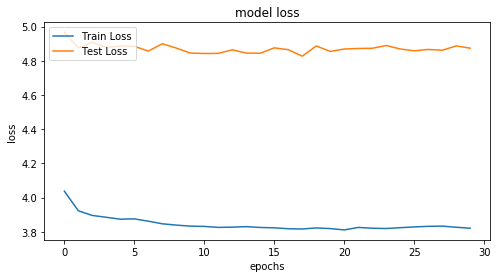

In [0]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper left')
plt.show()

## Second model

In [0]:
model = Sequential()
model.add(LSTM(4, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, y_train, epochs=2, batch_size=5000, validation_data=(X_test, y_test))

model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 14318824 samples, validate on 6136637 samples
Epoch 1/2





14318824/14318824 [==============================] - 59s 4us/step - loss: 5.8673 - val_loss: 5.8398
Epoch 2/2
14318824/14318824 [==============================] - 49s 3us/step - loss: 4.5462 - val_loss: 5.2470
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dropout_1 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 213
T

In [0]:
history=model.fit(X_train, y_train, epochs=5, batch_size=batch_size, validation_split=0.2,
         verbose=1,)

Train on 11455059 samples, validate on 2863765 samples
Epoch 1/5
11455059/11455059 [==============================] - 37s 3us/step - loss: 3.8817 - val_loss: 4.9452
Epoch 2/5
11455059/11455059 [==============================] - 37s 3us/step - loss: 3.8070 - val_loss: 4.7430
Epoch 3/5
11455059/11455059 [==============================] - 37s 3us/step - loss: 3.7803 - val_loss: 4.7588
Epoch 4/5
11455059/11455059 [==============================] - 36s 3us/step - loss: 3.7656 - val_loss: 4.7512
Epoch 5/5
11455059/11455059 [==============================] - 36s 3us/step - loss: 3.7506 - val_loss: 4.7292


In [0]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper left')
plt.show()

## Third model

In [0]:
model = Sequential()
model.add(GRU(32, 
               input_shape=(X_train.shape[1], X_train.shape[2]), 
               dropout=0.1,
               recurrent_dropout= 0.5,
               return_sequences=True
              ))

model.add(GRU(64, 
               activation='relu', 
               dropout=0.1,
               recurrent_dropout= 0.5,
              ))

model.add(Dense(1))

model.compile(optimizer='rmsprop', loss='mse')

history = model.fit(X_train, y_train, epochs=2, batch_size=5000, validation_data=(X_test, y_test))

model.summary()

In [0]:
history=model.fit(X_train, y_train, epochs=30, batch_size=bs, validation_split=0.2,
         verbose=1,)

In [0]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper left')
plt.show()

## Fourth model using only target 

In [0]:
# Modeling using only target (without features)
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=2, batch_size=1024, validation_data=(X_test, Y_test))

model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 14318798 samples, validate on 6136611 samples
Epoch 1/2





14318798/14318798 [==============================] - 335s 23us/step - loss: 2.2350 - val_loss: 4.7402
Epoch 2/2
14318798/14318798 [==============================] - 328s 23us/step - loss: 1.6303 - val_loss: 4.7438
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               52400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 5

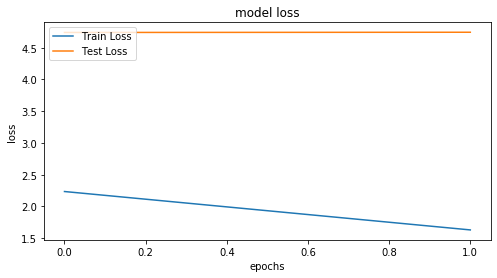

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper left')
plt.show();

# Save Model

In [0]:
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'